In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import img_to_array, load_img
import os
import glob
import re
from sklearn.preprocessing import StandardScaler
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications import VGG16
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

In [ ]:
!wget https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip -O dataset-resized.zip

--2024-08-12 16:44:39--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2024-08-12 16:44:40--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M   118MB/s    in 0.3s    

2024-08-12 16:44:42 (118 MB/s) - ‘dataset-resized.zip’ saved [42834870/42834870]



In [ ]:
!unzip dataset-resized.zip -d dataset

Archive:  dataset-resized.zip
   creating: dataset/dataset-resized/
  inflating: dataset/dataset-resized/.DS_Store  
   creating: dataset/__MACOSX/
   creating: dataset/__MACOSX/dataset-resized/
  inflating: dataset/__MACOSX/dataset-resized/._.DS_Store  
   creating: dataset/dataset-resized/cardboard/
  inflating: dataset/dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset/dataset-resized/car

In [ ]:
img_dir = 'dataset/dataset-resized/'

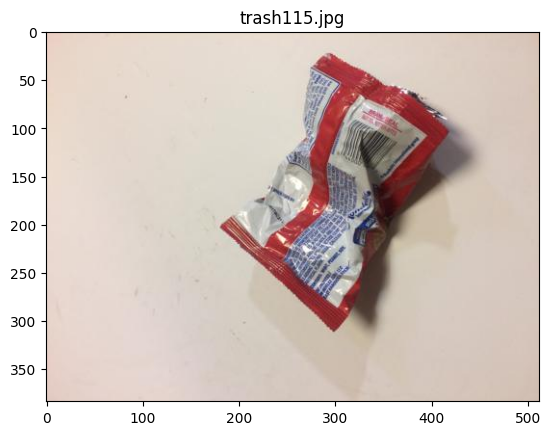

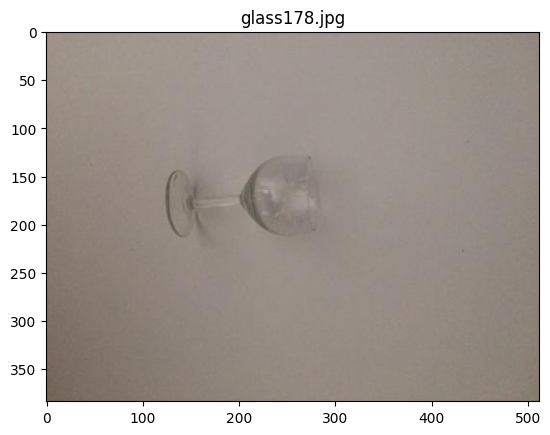

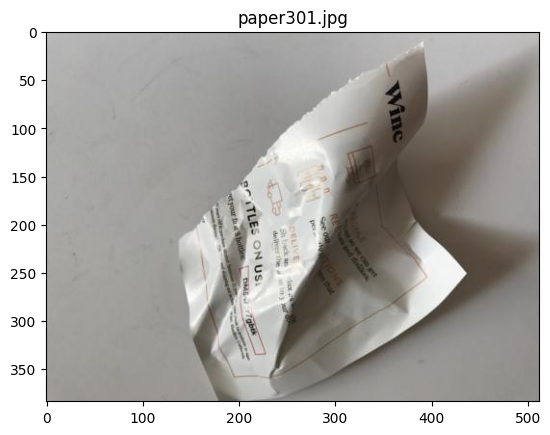

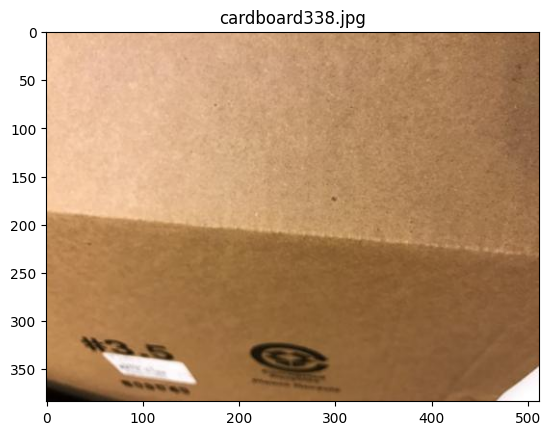

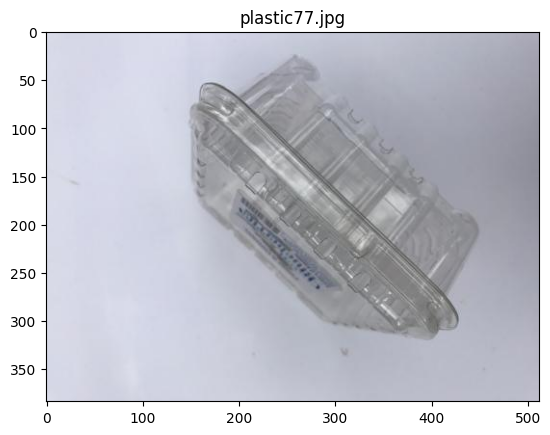

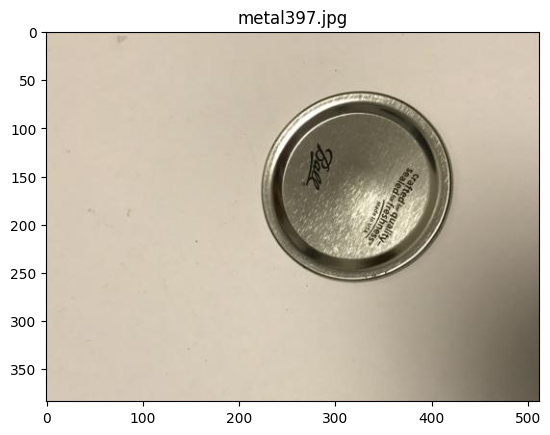

In [ ]:
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file.endswith(('.jpg', '.png')):
            img_path = os.path.join(root, file)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(file)
            plt.show()
            break  # Displaying only the first image for demonstration

In [ ]:
image_paths = glob.glob(os.path.join(img_dir, '*/*.jpg'))

In [ ]:
len(image_paths)

2527

In [ ]:
for img in image_paths:
    print(os.path.basename(img))
    break

metal90.jpg


In [ ]:
# Feature Extraction Functions
def extract_haralick(image):  # --> extracts textures
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)
    features = [graycoprops(glcm, prop).ravel() for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]
    return np.hstack(features)

def extract_color_histogram(image, bins=(8, 8, 8)):  # --> extracts colors
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_hu_moments(image):  # --> extracts shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments)
    return -np.sign(hu_moments) * np.log10(np.abs(hu_moments)).flatten()

def extract_lbp(image):  # --> extracts edges
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_sift(image, max_features=128):  # --> extracts keypoints
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros(max_features * 128)
    descriptors = descriptors[:max_features]
    if descriptors.shape[0] < max_features:
        descriptors = np.vstack([descriptors, np.zeros((max_features - descriptors.shape[0], 128))])
    return descriptors.flatten()

def extract_deep_features(image, model=None):  # --> extracts deep features
    if model is None:
        model = VGG16(weights='imagenet', include_top=False)
        model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = model.predict(image)
    return features.flatten()

# Combine all features
def extract_combined_features(image, deep_model):
    # haralick = extract_haralick(image)
    color_histogram = extract_color_histogram(image)
    hu_moments = extract_hu_moments(image)
    lbp = extract_lbp(image)
    sift = extract_sift(image)
    deep_features = extract_deep_features(image, deep_model)

    # Flatten all features to ensure they are 1D arrays
    features = [color_histogram, hu_moments, lbp, sift, deep_features]
    flat_features = [f.flatten() for f in features]

    combined_features = np.hstack(flat_features)
    return combined_features

In [ ]:
# Function to extract label from the filename
def extract_label(filename):
    match = re.match(r"([a-zA-Z]+)", filename)
    if match:
        return match.group(1)
    return None

# Load VGG16 model for deep features extraction
vgg_model = VGG16(weights="imagenet", include_top=False)

features = []
labels = []

for image_path in image_paths:
    image = cv2.imread(image_path)
    combined_features = extract_combined_features(image, vgg_model)
    features.append(combined_features.flatten())

    # Extract label from the filename
    filename = os.path.basename(image_path)
    label = extract_label(filename)
    labels.append(label)

features = np.array(features)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

1/1 [==============================] - 1s 536ms/step


In [ ]:
feature_shape = features[0].shape

for i in range(len(features)):
    if feature_shape != features[i].shape:
      print(f"not equal shapes for feature : {i}")
      break

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the feature vectors
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 2: Initialize and fit PCA
# Specify the number of components you want to keep
n_components = 2527
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features_scaled)

# Step 3: Check the shape of the transformed features
print("Original features shape:", features.shape)
print("Transformed features shape:", features_pca.shape)

Original features shape: (2527, 42059)
Transformed features shape: (2527, 2527)


In [ ]:
features_file = 'features_pca.npy'
labels_file = 'labels.npy'

np.save(features_file, features_pca)
np.save(labels_file, labels)

In [ ]:
features_file = 'features_pca.npy'

features_pca = np.load(features_file)

# Print or use the loaded features
print(features.shape)

(2527, 42059)


In [ ]:
labels_file = 'labels.npy'

labels = np.load(labels_file)

# Print or use the loaded labels
print(labels.shape, np.unique(labels))

(2527,) [0 1 2 3 4 5]


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Train SVM model
model = SVC(
    kernel='linear',
    C=1.0,
    probability=False,
    shrinking=True,
    tol=1e-4,
    max_iter=-1,
    class_weight='balanced',
    decision_function_shape='ovr',
    random_state=42
)

# fit model
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

              precision    recall  f1-score   support

   cardboard       0.94      0.93      0.93        82
       glass       0.79      0.87      0.83       109
       metal       0.86      0.74      0.79        80
       paper       0.88      0.91      0.90       117
     plastic       0.81      0.81      0.81        98
       trash       0.73      0.55      0.63        20

    accuracy                           0.84       506
   macro avg       0.83      0.80      0.81       506
weighted avg       0.84      0.84      0.84       506

Accuracy: 0.84


In [ ]:
from joblib import dump

# Specify the file path to save the model
model_file = 'Trashnet_svm_model.joblib'

# Save the model to disk
dump(model, model_file)

In [ ]:
from joblib import load

# Load the saved model
loaded_svm_model = load(model_file)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=2000,
    random_state=42,
    max_depth=None,  # no maximum depth
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    class_weight=None,
    criterion='gini'
)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Train Random Forest model
model = ExtraTreesClassifier(
    n_estimators=2000,
    random_state=42,
    max_depth=100,
    min_samples_split=2,
    min_samples_leaf=1,
)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')